In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform

%matplotlib inline

In [8]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking data frame. Data only contains numerical inputs from V1 to V28

# EDA

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


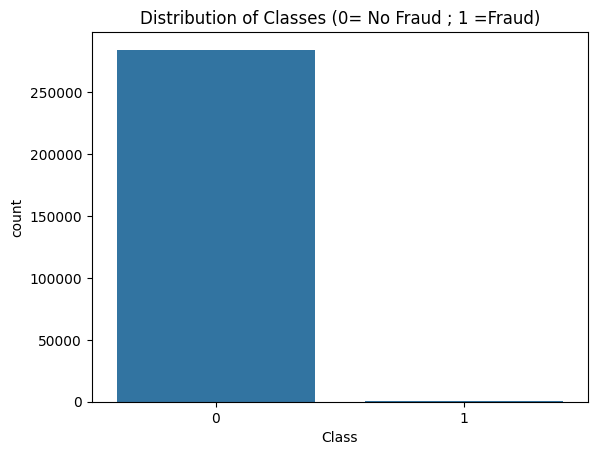

In [27]:
#fraud cases are extremely rare(only 0.172% of all transactions)
#0 is no fraud
#1 is fraud
sns.countplot(x='Class', data =df);
plt.title('Distribution of Classes (0= No Fraud ; 1 =Fraud)');
plt.show

print(df['Class'].value_counts(normalize=True)) #percentage of fraud and no fraud cases

In [35]:
print(df.describe()) 
print(df.shape)

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [41]:
df.info() #no missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Correlation Heat Map

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


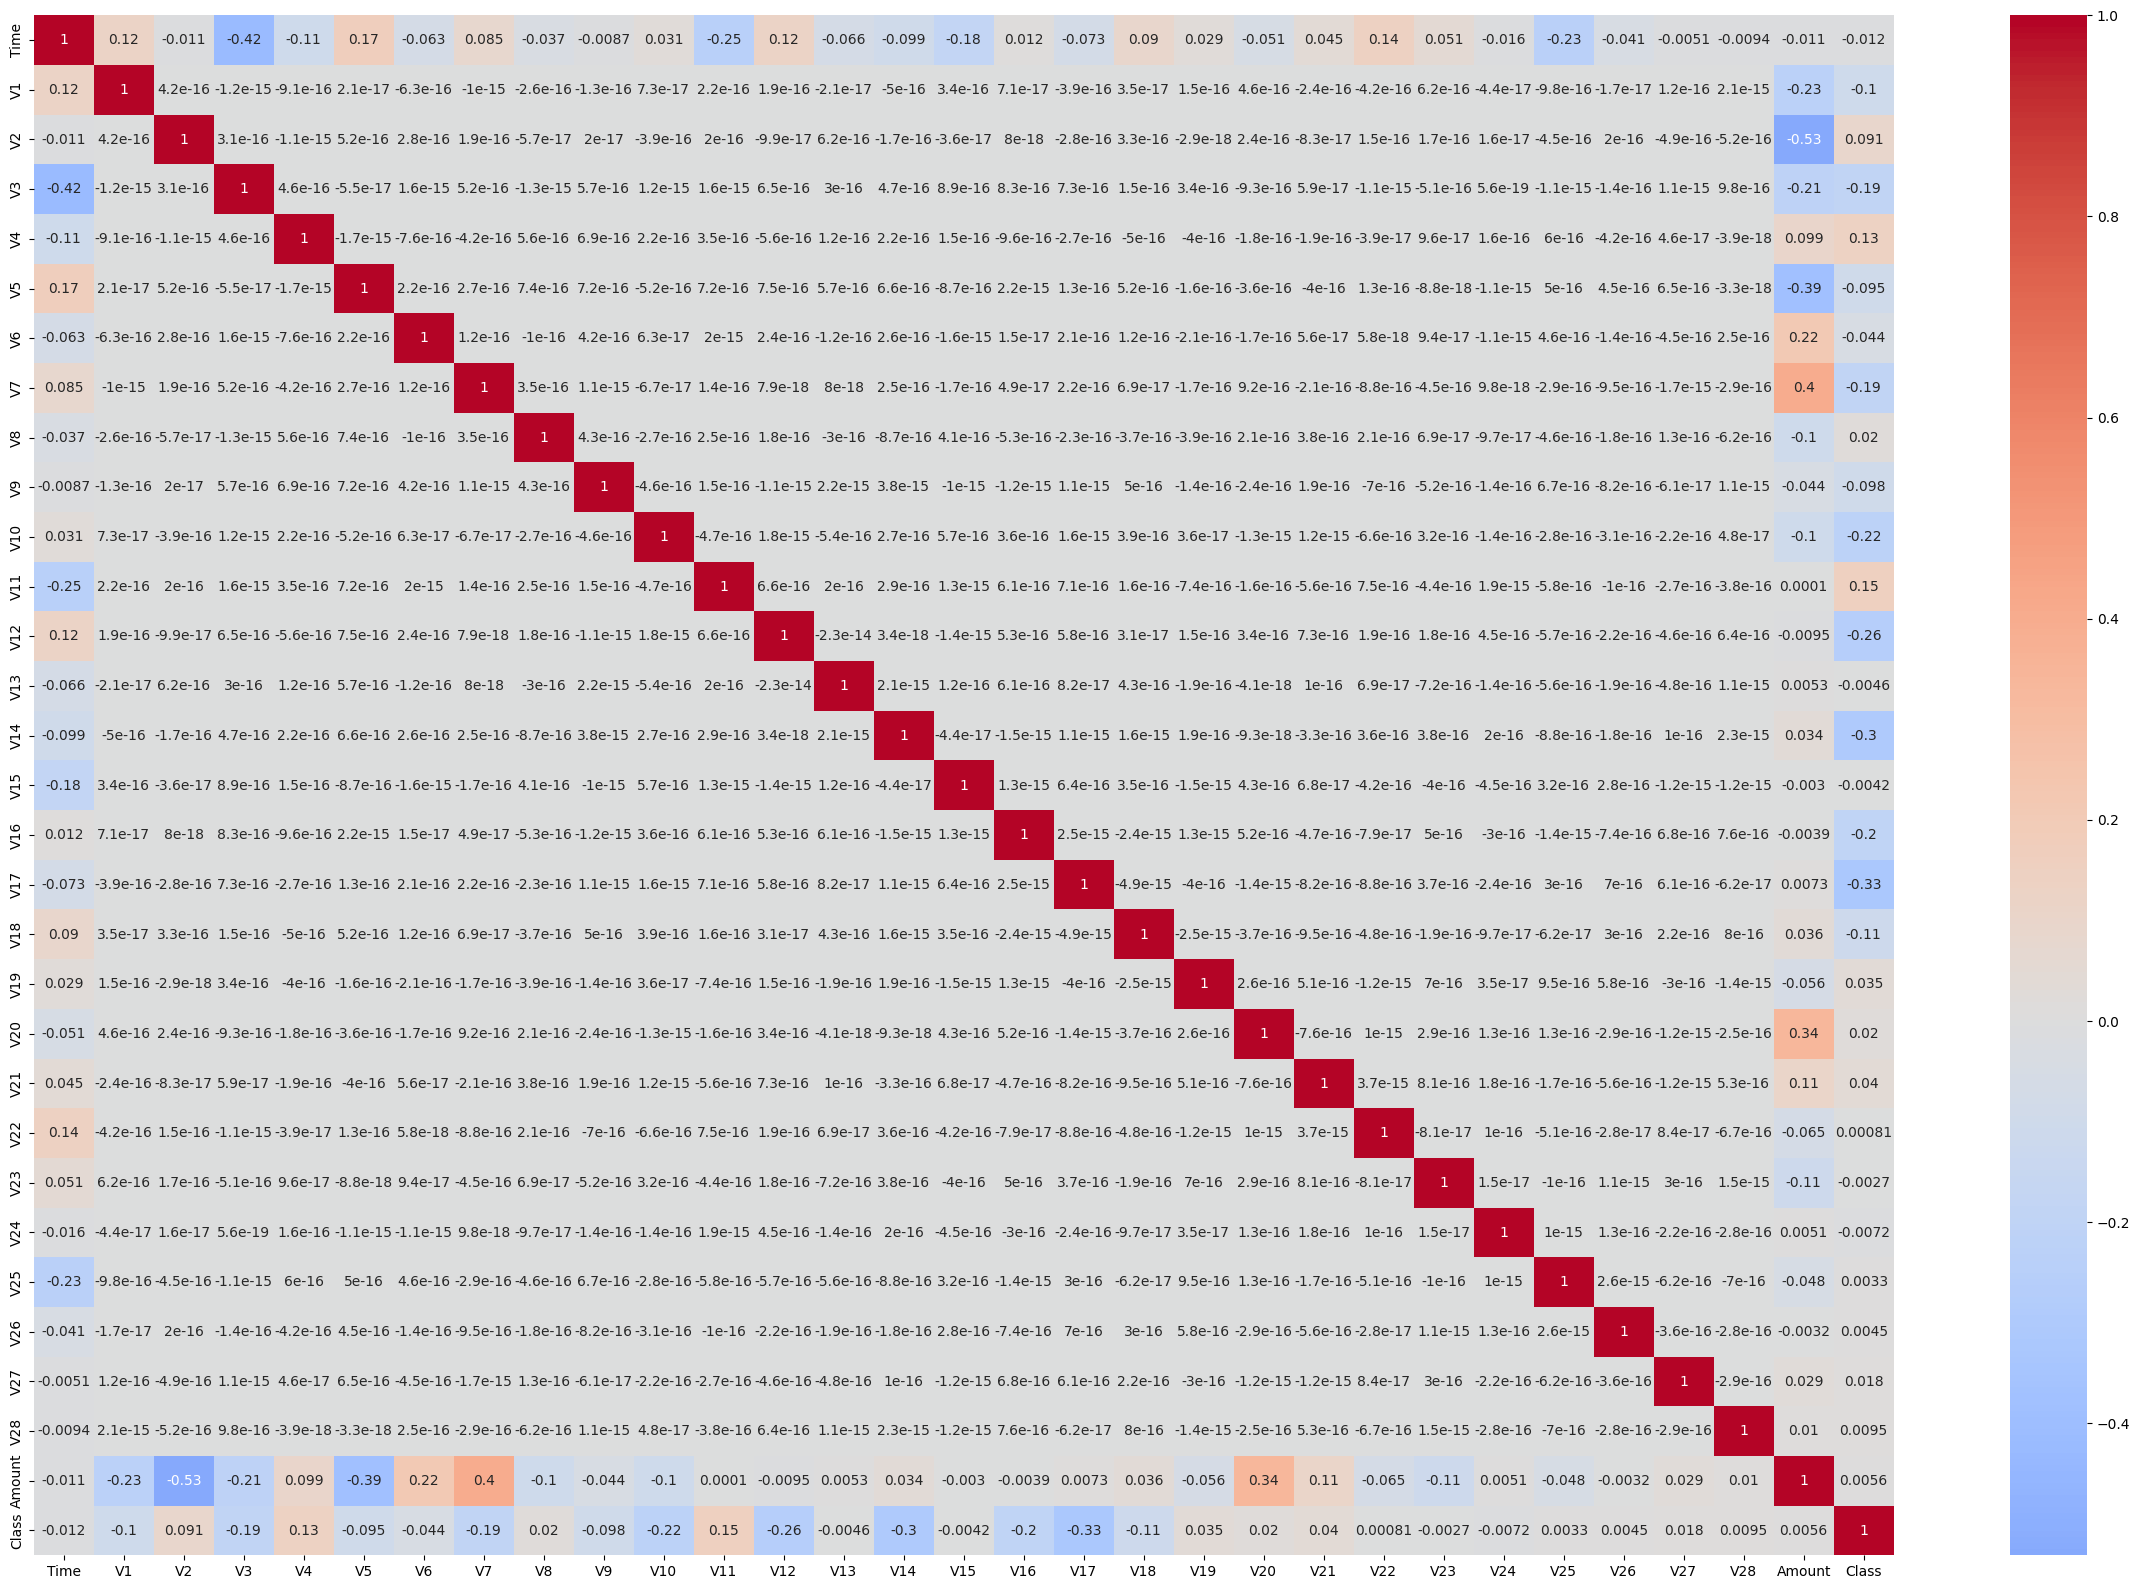

In [68]:
#correlation heat map to see if any variables are highly correlated to class
correlation_mat=df.corr()

plt.figure(figsize=(30,20))
sns.heatmap(correlation_mat,cmap='coolwarm', annot=True, center=0)

corr_with_class = correlation_mat['Class'].sort_values(ascending=False)
print(corr_with_class)

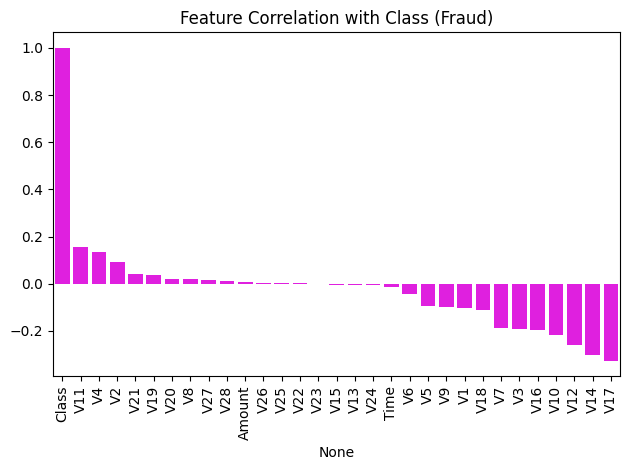

In [84]:
#Heatmap with Class Correlation values only 
plt.figure
sns.barplot(x=corr_with_class.index, y=corr_with_class.values, color='magenta')
plt.xticks(rotation=90)
plt.title("Feature Correlation with Class (Fraud)")
plt.tight_layout()
plt.show()

## Boxplot with Features that are most revelant to Fraud detection [Gives a good idea of what variables to inculde in our model generation]

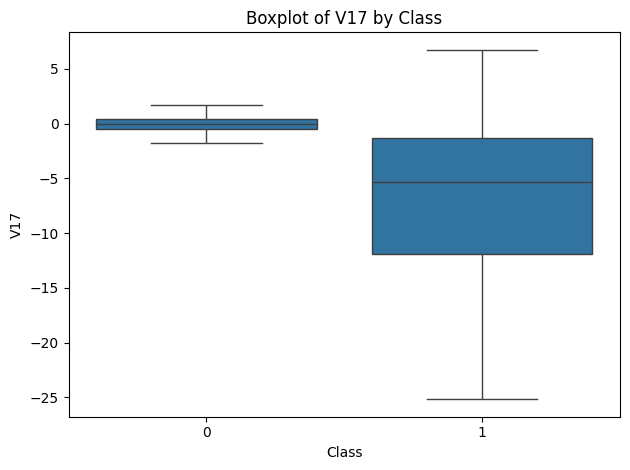

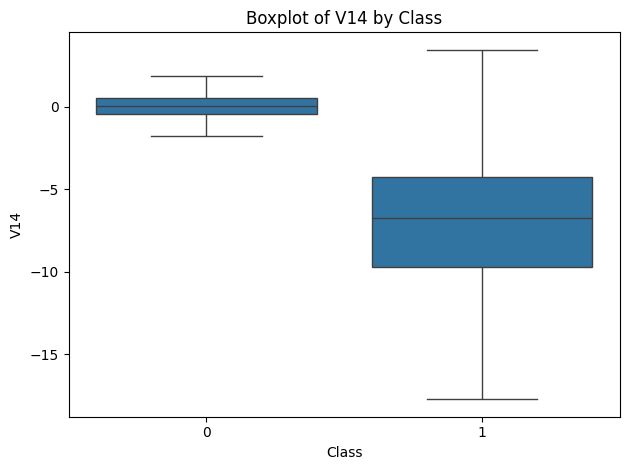

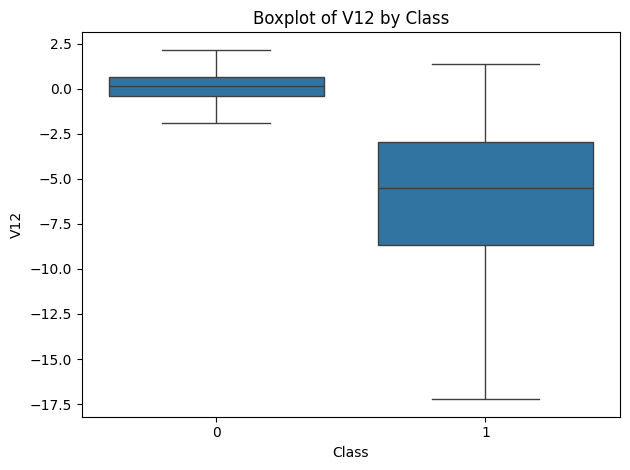

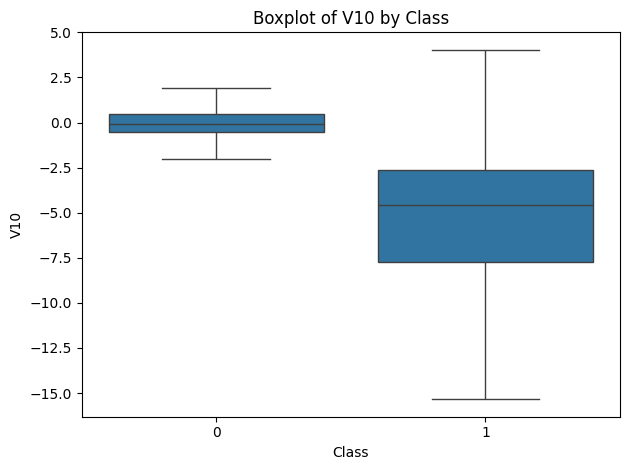

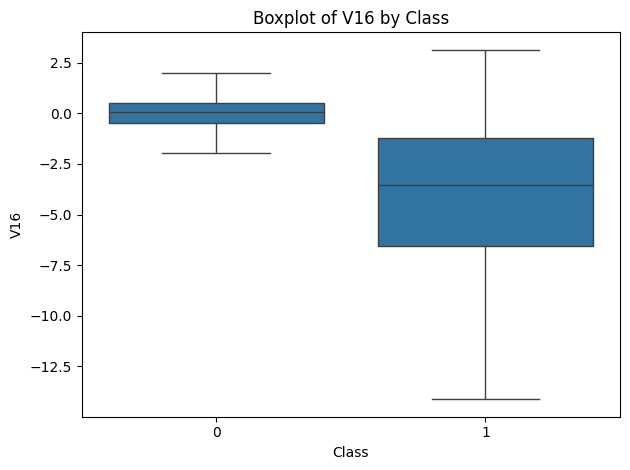

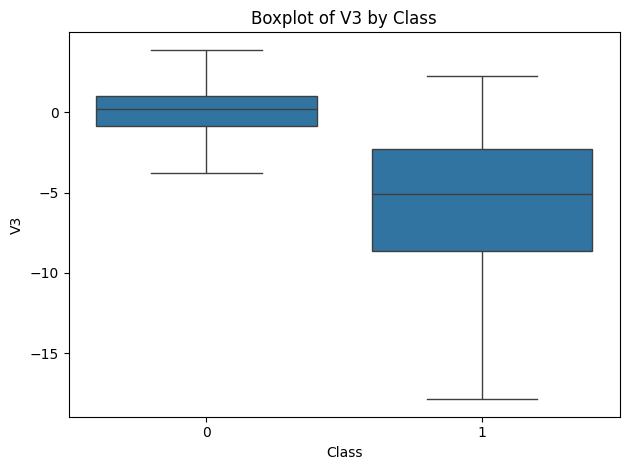

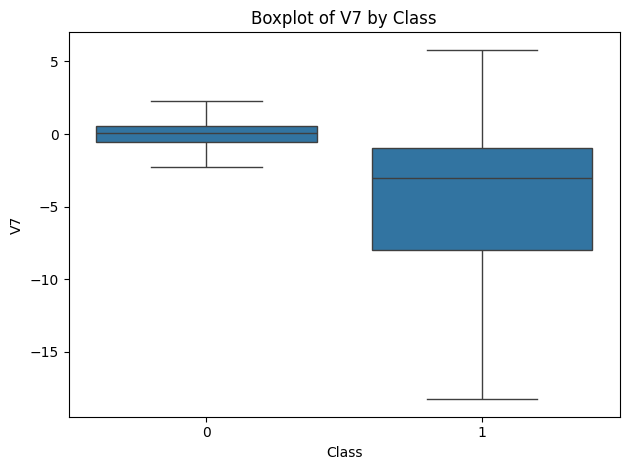

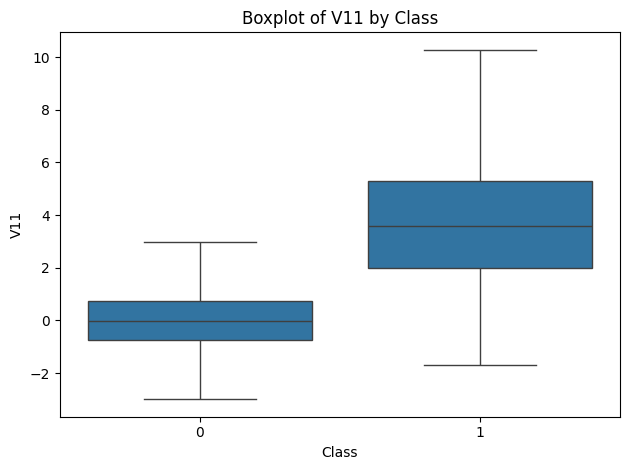

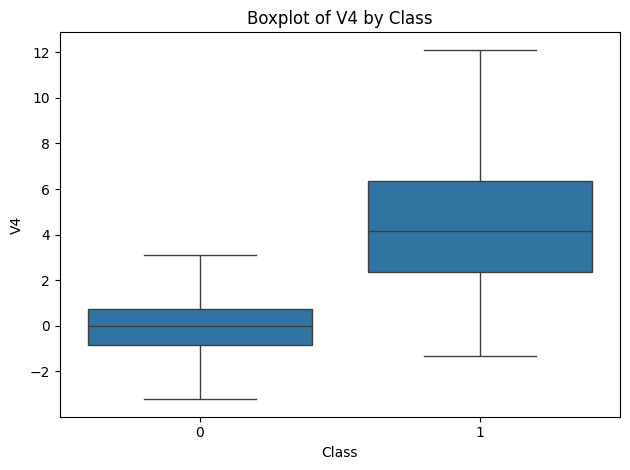

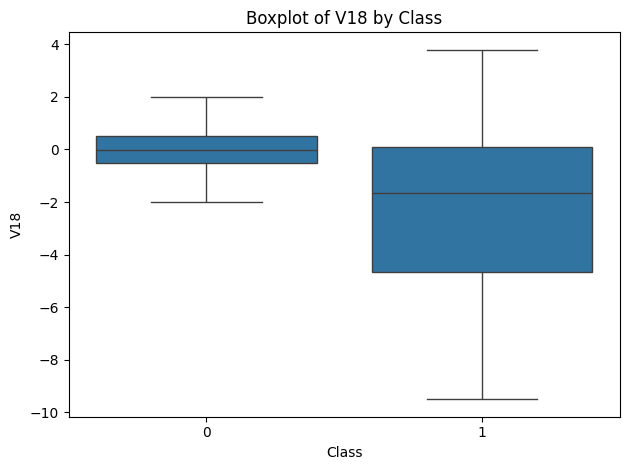

In [109]:
#compute correlations with Class
correlations=df.corr()['Class'].drop('Class').abs().sort_values(ascending = False)

#only getting top 10 correlation
top_correlations= correlations.head(10).index

#plot boxplot for top features
for column in top_correlations:
    sns.boxplot(x='Class',y= column, data=df, showfliers=False)
    plt.title(f'Boxplot of {column} by Class')
    plt.tight_layout()
    plt.show()

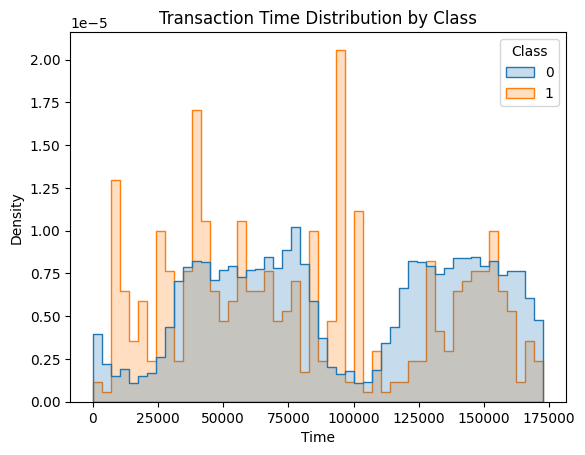

In [105]:
sns.histplot(data=df, x="Time", hue="Class", bins=50, element="step", stat="density", common_norm=False)
plt.title("Transaction Time Distribution by Class")
plt.show()

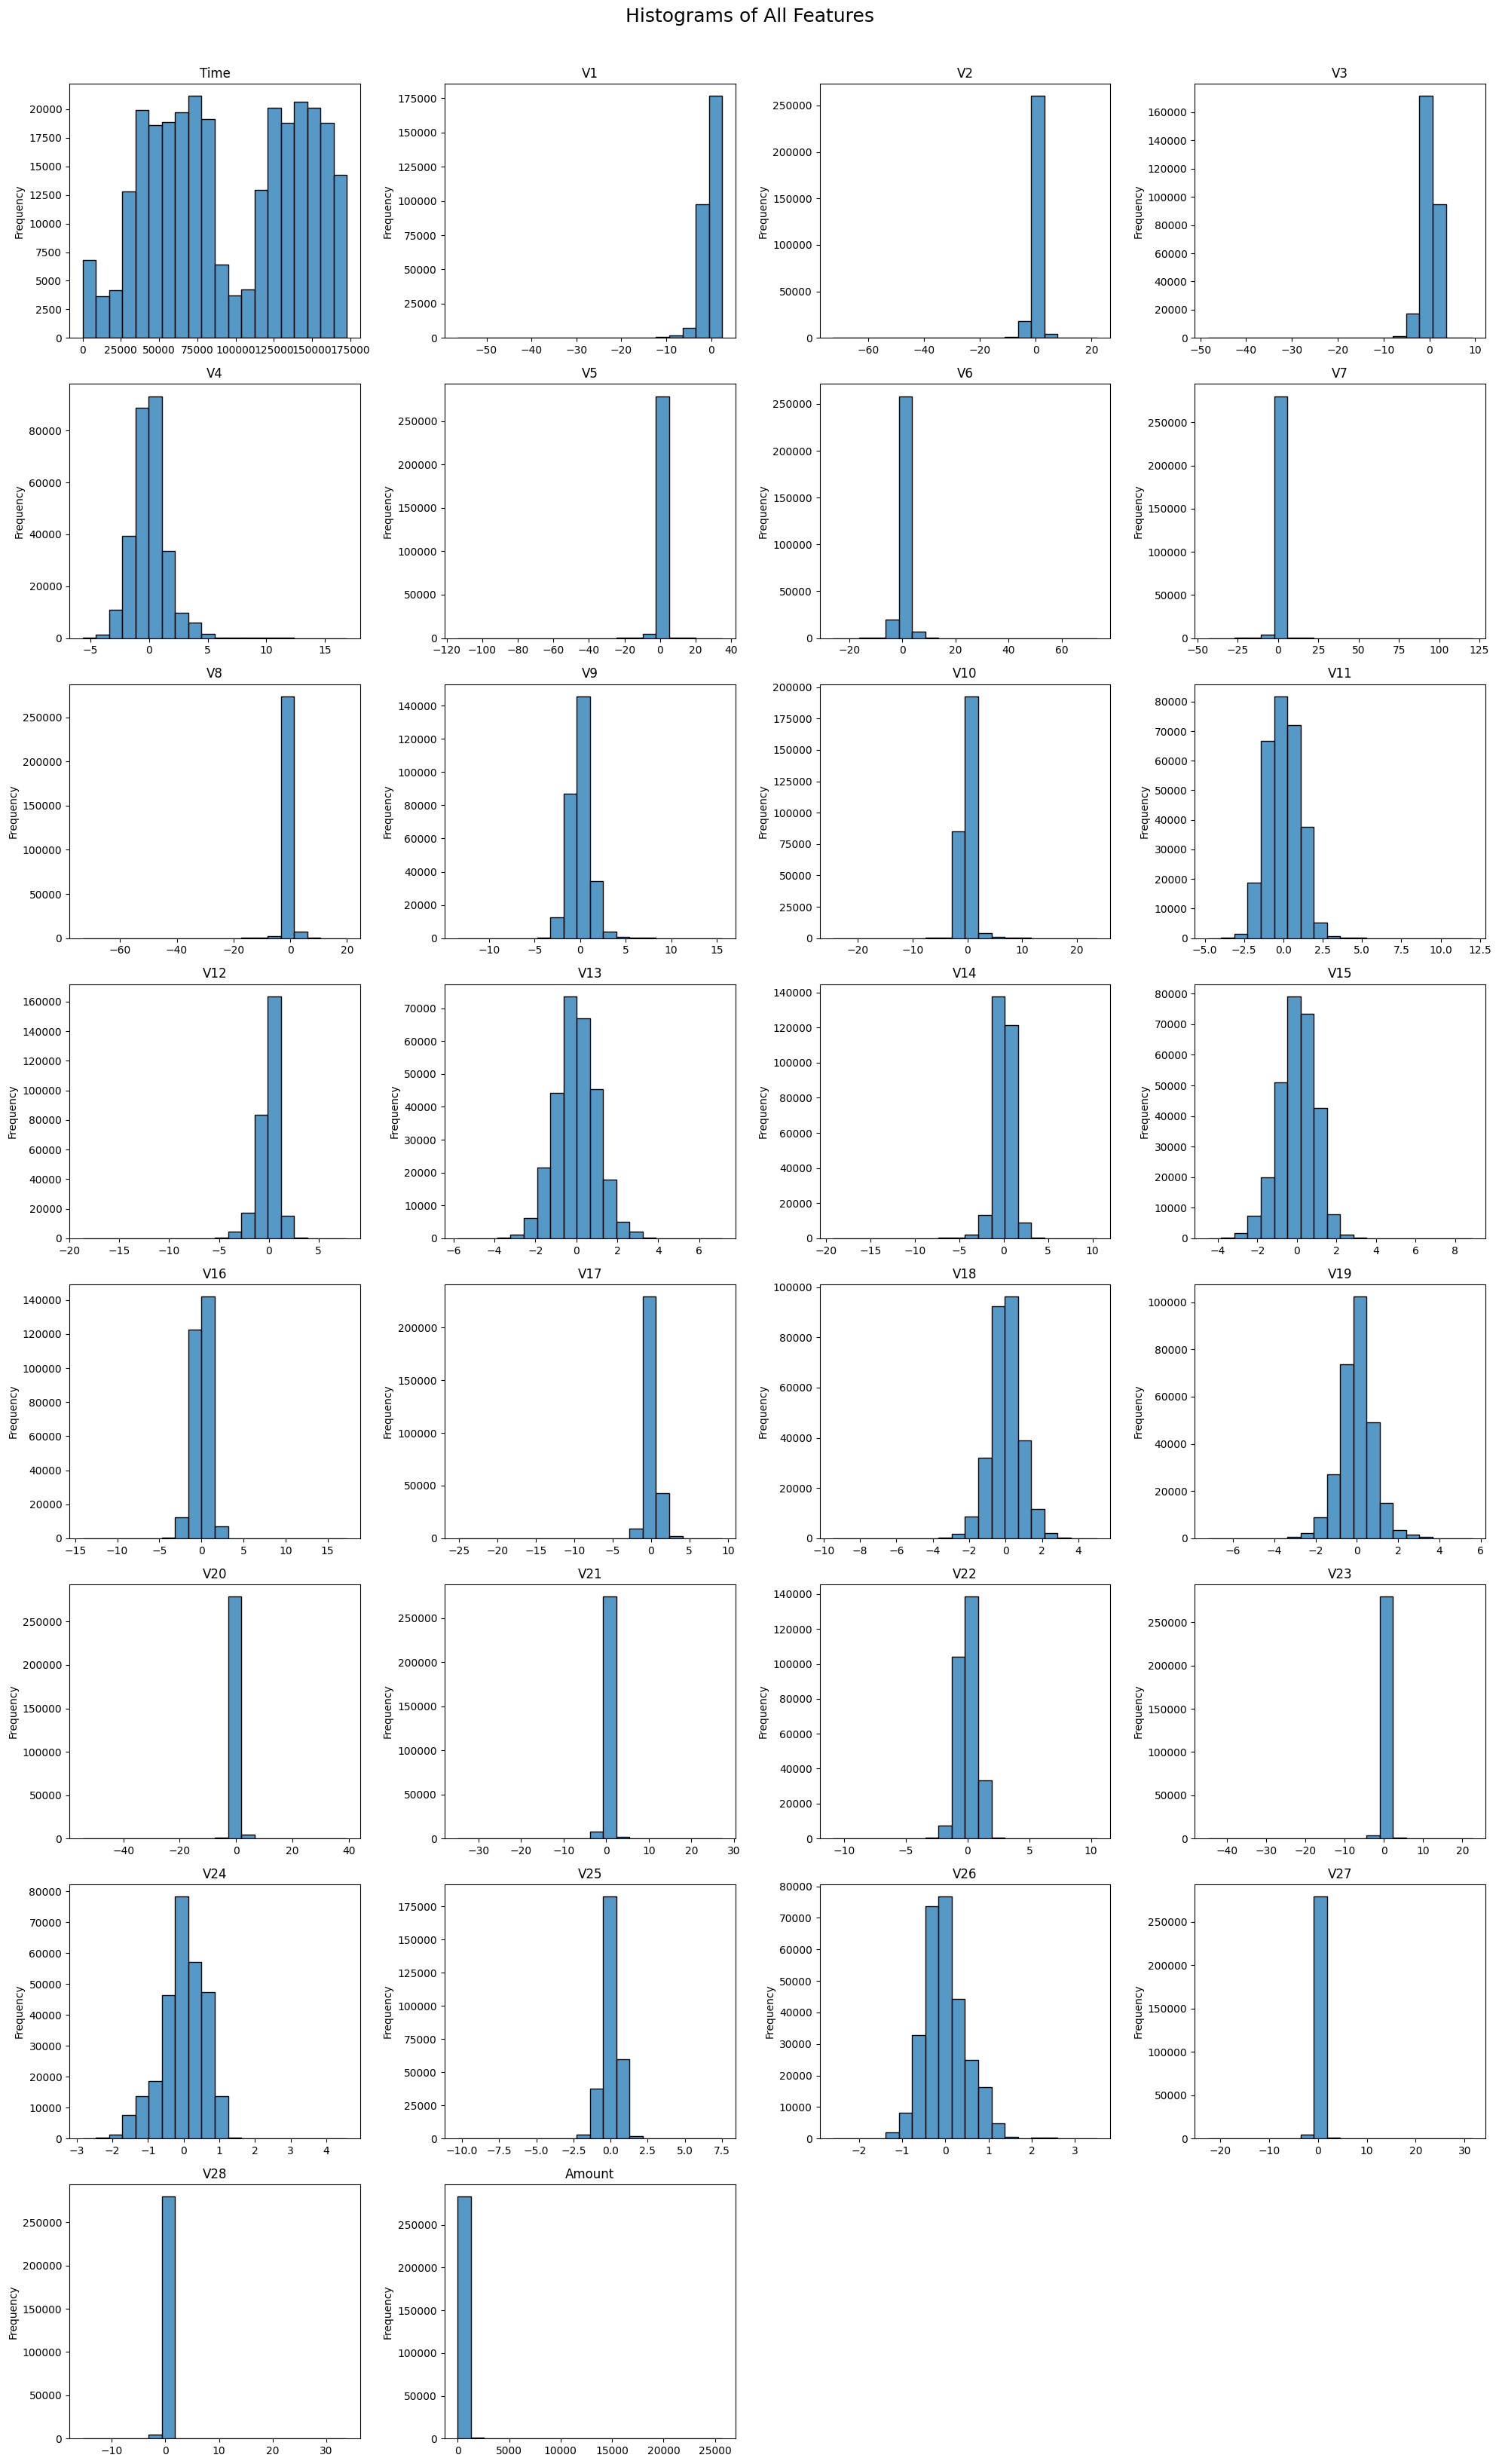

In [116]:
#Histogrm to visualize centrality and distribution
columns_to_plot= df.drop('Class', axis=1).columns
n_cols=4
n_rows=int(np.ceil(len(columns_to_plot)/ n_cols))

plt.figure(figsize=(n_cols*5, n_rows *4))

for i, var in enumerate(columns_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[var], kde=False, bins=20)
    plt.title(f'{var}')
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Histograms of All Features', fontsize=18, y=1.02)
plt.show()

## SMOTE for Imbalanced Data

In [137]:
# Applying SMOTE for imbalanced class types
X = df.drop('Class', axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Apply smote
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape: {y_train.value_counts()}')
print(f'Resampled dataset shape: {y_train_smote.value_counts()}')

Original dataset shape: Class
0    227451
1       394
Name: count, dtype: int64
Resampled dataset shape: Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
# Standardize features (important for SVM and MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Strategies

## Logistic Regression Model (Baseline)

## Random Forest Classifier

In [151]:
#initializing model
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 42, n_jobs = -1)

#fitting the model
model_rf.fit(X_train_smote, y_train_smote)

#predicting y from our x_test set
y_pred = model_rf.predict(X_test)

#comparing actual y to predicted y
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[56846    18]
 [   18    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# Random forest hyperparameter tuning

# Subsample training data (20%) for faster tuning
X_sub, _, y_sub, _ = train_test_split(
    X_train_scaled, y_train,
    train_size = 0.2,
    stratify = y_train,
    random_state = 42
)

rf_tune = RandomForestClassifier(random_state = 42, n_jobs = -1)

rf_params = {
    'n_estimators': randint(50, 150),  # lower for search
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_search = RandomizedSearchCV(
    rf_tune,
    param_distributions = rf_params,
    n_iter = 15,  # fewer iterations
    scoring  ='f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)

rf_search.fit(X_sub, y_sub)
print("Best RF parameters:", rf_search.best_params_)

In [ ]:
# Retrain random forest model on full dataset
best_rf = RandomForestClassifier(
    **rf_search.best_params_,
    random_state = 42,
    n_jobs = -1
)
best_rf.fit(X_train_scaled, y_train)

y_pred = best_rf.predict(X_test)

# Comparing actual y to predicted y
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## XGBoost or LightGBM

## Decision Tree

## Linear SVM

In [ ]:
svm_model = LinearSVC(max_iter = 10000, random_state = 42)
svm_model.fit(X_train_scaled, y_train)

preds_svm = svm_model.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, preds_svm))
print(classification_report(y_test, preds_svm))

In [ ]:
# Linear SVM hyperparameter tuning
svm_tune = LinearSVC(max_iter = 10000, random_state = 42)

svm_params = {
    'C': uniform(0.001, 10),
    'class_weight': [None, 'balanced']
}

svm_search = RandomizedSearchCV(
    svm_tune,
    param_distributions = svm_params,
    n_iter = 20,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)
svm_search.fit(X_train_scaled, y_train)

print("Best Linear SVM parameters:", svm_search.best_params_)

In [ ]:
# Retrain model
best_svm = LinearSVC(**svm_search.best_params_, random_state = 42, max_iter = 5000)
best_svm.fit(X_train_scaled, y_train)

preds_svm = best_svm.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, preds_svm))
print(classification_report(y_test, preds_svm))

## Neural Network (MLP)

In [ ]:
mlp_model = MLPClassifier(
    hidden_layer_sizes = (50,),
    max_iter = 500,
    random_state = 42,
    early_stopping = True
)
mlp_model.fit(X_train_scaled, y_train)

probs_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
preds_mlp = mlp_model.predict(X_test_scaled)
# preds_mlp = (probs_mlp >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, probs_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_mlp))
print(classification_report(y_test, preds_mlp))

In [ ]:
# Neural network hyperparameter tuning
mlp_tune = MLPClassifier(max_iter = 300, random_state = 42, early_stopping = True)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_search = RandomizedSearchCV(
    mlp_tune, 
    param_distributions = mlp_params,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2
)
mlp_search.fit(X_train_scaled, y_train)

print("Best MLP parameters:", mlp_search.best_params_)

In [ ]:
# Retrain neural net model
best_mlp = MLPClassifier(**mlp_search.best_params_, random_state = 42, early_stopping = True)
best_mlp.fit(X_train_scaled, y_train)

probs_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]
preds_mlp = best_mlp.predict(X_test_scaled)
# preds_mlp = (probs_mlp >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, probs_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_mlp))
print(classification_report(y_test, preds_mlp))

## Naive Bayes (Gaussian)

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

probs_nb = nb_model.predict_proba(X_test_scaled)[:, 1]
preds_nb = nb_model.predict(X_test_scaled)

print("AUC:", roc_auc_score(y_test, probs_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_nb))
print(classification_report(y_test, preds_nb))

In [ ]:
# Naive bayes hyperparameter tuning
nb_params = {
    'var_smoothing': np.logspace(-9, -2, 8)
}

nb_search = RandomizedSearchCV(
    GaussianNB(),
    param_distributions = nb_params,
    n_iter = 8,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)
nb_search.fit(X_train_scaled, y_train)

print("Best NB parameters:", nb_search.best_params_)

In [ ]:
# Retrain naive bayes model
best_nb = GaussianNB(**nb_search.best_params_)
best_nb.fit(X_train_scaled, y_train)

probs_nb = best_nb.predict_proba(X_test_scaled)[:, 1]
preds_nb = best_nb.predict(X_test_scaled)

print("AUC:", roc_auc_score(y_test, probs_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_nb))
print(classification_report(y_test, preds_nb))